# Deep Learning with Python 
# 6.3 - Recurrent Neural Networks

All neural networks we have seen so far do not maintain **state** between processing inputs. This means that each input is processed independently, and previous inputs do not affect the gradient updates to the weights of a model for the current input. 

To get around this problem, we fed each sequence of inputs to the NN in one go. E.g. each IMDb review can be considered as a sequence of words, but the NN will receive the entire review in one go instead of parsing it word by word (or word-vector by word-vector).

RNN **maintains a state between inputs** but the **state is reset between samples**. The output of the current input will act as a feedback input along with the next input for a given sample. In this case, each sample is a sequence of inputs. 

This is called the **forward pass**

## Forward Pass of an RNN
- RNN takes as input a sequence of vectors (encoded as 2D `numpy` tensors). 
- Loops over timesteps and after each timestep it considers its urrent state at `t` and the input at `t` (of shape `input_features`) and combines them to obtain the output at `t`.
- Then sets the state for the next step. 

In [ ]:
# The state at t - initially this will be 0
state_t = 0 

# Iterate over sequence elements
for input_t in input_seqence:
    # Uses the current input and state to compute output
    output_t = f(input_t, state_t)

Assume that the transformation of the current input and the current state to produce the current output uses kernel matrices `W` and `U` along with a bias vector `b.

In [ ]:
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

Writing a complete naive `numpy` implementation of an RNN's update based on an input and state.

In [8]:
import numpy as np

In [9]:
timesteps = 100

# Dimensionality of the input feature space
input_features = 32

# Dimensionality of the output feature space
output_features = 64

# Input data is random noise for the sake of this example
# At each of the timesteps, we have the same number of features
inputs = np.random.random((timesteps, input_features))

In [10]:
# Initial state (prior to any training) will be all zeros
state_t = np.zeros((output_features,))

In [11]:
# Defining random weight matrices
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

In [12]:
# Create an empty list to store the outputs produced at each timestep
successive_outputs = []

In [13]:
# `input_t` is a vector of shape (input_features, )
for input_t in inputs:
    # Using the hyperbolic tangent activation function
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    
    # Append this outout to the list of computed outputs
    successive_outputs.append(output_t)
    
    # The state for the next timestep will be the current output
    state_t = output_t

In [14]:
# The final output is a 2D tensor of shape `(timesteps, output_features)`
final_output_sequence = np.concatenate(successive_outputs, axis=0)

This is the simplest variant of an RNN. Many other RNN architectures exist, and all of them have different ways of using the current output or state as an input in computing the next state. 

The output of the RNN is a tensor of shape `(timesteps, output_features)`. The output features for timestep `t` will contain information about outputs of **all timesteps up to and including `t`**. This means we don't often need the entire output tensor for an RNN, and are mostly interested in the final O/P.

## RNN and Return Sequences
When using the `keras` RNN layer, we have the option of specifying whether we want a 3D output tensor which contains all output features for all timesteps for all samples in the batch, or whether we want only the last output for each input sequence. 

These are controlled by the `return_sequences` constructor argument.

### Returns only the Last Output for Each Sequence

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

In [16]:
model = Sequential()

# Embedding layer will accept samples containing upto 10000
# different words and will encode each word as a 32-dimensional vector
model.add(Embedding(10000, 32))

# Recurrent layer
model.add(SimpleRNN(32))

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


### Returns the Full State Sequence

In [18]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


## Tracking Multiple Recurrent Layers
Stacking multiple recurrent layers in sequence increases the representational power of a network. To do this, all intermediate recurrent layers must return the full sequences. Can't just return the last output.

In [19]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))

# for the last recurrent layer, we need not return outputs for all timesteps
model.add(SimpleRNN(32))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


## IMDb RNN
Using a recurrent neural network on the IMDb movie dataset. 

### Importing Dataset

In [21]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

In [22]:
# Number of words to consider as features
max_features = 10000

# Cuts off texts after this many words (among max_features most common words)
maxlen = 500

# The RNN will process the reviews in batches of 32
batch_size = 32

In [23]:
# for loading IMDB dataset from a pickle file
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
# Data is loaded as lists of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# restore np.load for future normal usage
np.load = np_load_old

In [24]:
# Checking the number of training and test sequences 
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


In [25]:
print('Pad Sequences (samples x time)')
input_train = sequence.pad_sequences(x_train, maxlen=maxlen)
input_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Pad Sequences (samples x time)


In [27]:
input_train.shape

(25000, 500)

In [29]:
input_test.shape

(25000, 500)

In [28]:
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  (25000,)
x_test shape:  (25000,)


### Instantiating a Sequential Model

In [29]:
from tensorflow.keras.models import Sequential

In [30]:
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN

In [31]:
# Instantiate a sequential model
model = Sequential()

# First layer will convert sequences containing upto 10k words
# into 32-dimensional vectors
model.add(Embedding(max_features, 32))

# Simple RNN layer
model.add(SimpleRNN(32))

# Binary classification so a single unit that predicts a 
# probability between 0 and 1 that input belongs to positive class
model.add(Dense(1, activation='sigmoid'))

### Compiling the Model

In [32]:
model.compile(optimizer='rmsprop', 
             loss='binary_crossentropy', 
             metrics=['acc'])

### Training the Model

In [30]:
history = model.fit(input_train, y_train, 
                   epochs=10, batch_size=128,
                   validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 27s 1ms/sample - loss: 0.5392 - acc: 0.7230 - val_loss: 0.4069 - val_acc: 0.8280
Epoch 2/10
20000/20000 [==============================] - 30s 1ms/sample - loss: 0.3387 - acc: 0.8619 - val_loss: 0.4118 - val_acc: 0.8094
Epoch 3/10
20000/20000 [==============================] - 31s 2ms/sample - loss: 0.2643 - acc: 0.8970 - val_loss: 0.4542 - val_acc: 0.7906
Epoch 4/10
20000/20000 [==============================] - 31s 2ms/sample - loss: 0.2175 - acc: 0.9182 - val_loss: 0.3658 - val_acc: 0.8488
Epoch 5/10
20000/20000 [==============================] - 34s 2ms/sample - loss: 0.1708 - acc: 0.9388 - val_loss: 0.3683 - val_acc: 0.8620
Epoch 6/10
20000/20000 [==============================] - 32s 2ms/sample - loss: 0.1319 - acc: 0.9543 - val_loss: 0.4009 - val_acc: 0.8646
Epoch 7/10
20000/20000 [==============================] - 32s 2ms/sample - loss: 0.0972 - acc: 0.9675 - val_loss: 0.4

### Visualizing Results

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
# Extracting data
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

Text(0.5, 1.0, 'RNN IMDb - Accuracy')

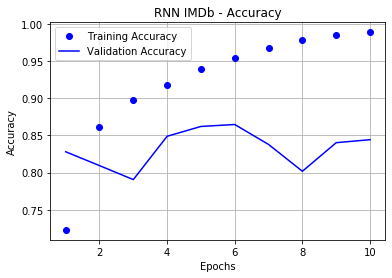

In [37]:
# Plotting accuracy
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.grid(True)
plt.legend(); plt.title('RNN IMDb - Accuracy')

Text(0.5, 1.0, 'RNN IMDb - Loss')

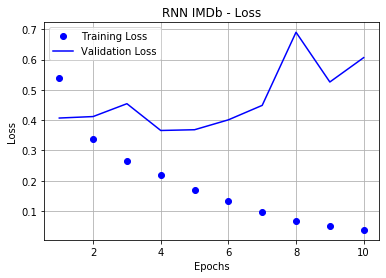

In [38]:
# Plotting loss
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.grid(True);
plt.legend(); plt.title('RNN IMDb - Loss')

## `LSTM` 
- Long short term memory
- A kind of RNN layer that allows RNNs to bypass the **vanishing gradient** problem: adding more and more SimpleRNN layers to the model will make it untrainable.
- This is because the backpropagation gradients will become too small to make meaningful updates to the weights of the RNN layer.
- So SimpleRNN layers cannot remember information about a sufficiently large number of timesteps.
- LSTM layers bypass this problem by including a **carry track** - best visualized as a "conveyor belt" running parallel to the I/O tracks of an RNN.
- Information from any timestep can be placed on the carry track and "fast forwarded" to a RNN block later in the model.

### Some Mathematics
- The LSTM layer will still compute an output using an input and a state, but will also use the **carry** produced by the previous step.
- `output_t  = activation(dot(W_o, input_t) + dot(U_o, state_t) + dot(V_0, c_t) + b_o)` where `W_o, U_o, V_o` are all weight matrices or kernels for calculating an output using the input, state, and carry at time t, while `b_0` is the biasing vector. 
- The carry `c_t+1` for any given step is computed using a product of three different vectors for each LSTM timestep - `i_t, f_t, k_t`.
- These are computed using three different versions of weight matrices and biases using an activation function and dot products.
- Concretely
    - `i_t = activation(dot(W_i, input_t) + dot(U_i, input_t) + b_i`
    - `k_t = activation(dot(W_k, input_t) + dot(U_k, input_t) + b_k`
    - `f_t = activation(dot(W_f, input_t) + dot(U_f, input_t) + b_f`
    - `c_t+1 = i_t x k_t + c_t x f_t`

### Interpretation
- There is no point in trying to interpret the role `i`, `k`, or `f` or their products play in computing the `c_t` for any given LSTM layer.
- This is because their products and their significance depends a lot on the actual values of the weight matrices.
- These weight matrices are different for each training cycle, so there is no standard function of each term.
- THe specification of an RNN cell (`i`, `f`, `k`, and the weight matrices) defines the hypothesis space - the space in which we will search for a good model configuration - but **not what the cell does - this depends on the cell weights**.
- Think of the combinatio ns of operations making up an RNN cell as a **set of constraints** on your search for the optimal model, and not **design** in the engineering sense.

## Concrete `LSTM` Example

In [33]:
from tensorflow.keras.layers import LSTM

In [34]:
# Instantiate a sequential model
model = Sequential()

# First layer will still be an embedding layer that will
# encode words as 32-dimension vectors
model.add(Embedding(max_features, 32))

# A 32 cell ? LSTM model
model.add(LSTM(32))

# Add the final classification layer
model.add(Dense(1, activation='sigmoid'))

In [35]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy', 
             metrics=['acc'])

In [36]:
history_LSTM = model.fit(input_train, y_train, 
                        epochs=10, batch_size=128, 
                        validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
20000/20000 [==============================] - 130s 7ms/sample - loss: 0.5149 - acc: 0.7534 - val_loss: 0.3315 - val_acc: 0.8706
Epoch 2/10
20000/20000 [==============================] - 123s 6ms/sample - loss: 0.2939 - acc: 0.8850 - val_loss: 0.4016 - val_acc: 0.8586
Epoch 3/10
20000/20000 [==============================] - 121s 6ms/sample - loss: 0.2346 - acc: 0.9115 - val_loss: 0.2893 - val_acc: 0.8786
Epoch 4/10
20000/20000 [==============================] - 117s 6ms/sample - loss: 0.2018 - acc: 0.9263 - val_loss: 0.2890 - val_acc: 0.8852
Epoch 5/10
20000/20000 [==============================] - 119s 6ms/sample - loss: 0.1733 - acc: 0.9385 - val_loss: 0.3125 - val_acc: 0.8652
Epoch 6/10
20000/20000 [==============================] - 125s 6ms/sample - loss: 0.1575 - acc: 0.9449 - val_loss: 0.3185 - val_acc: 0.8726
Epoch 7/10
20000/20000 [==============================] - 121s 

In [38]:
# Save the LSTM model
model.save('LSTM_IMDB.h5')

## Note to Self
Training an LSTM model takes a lot of time. The `SimpleRNN` model took only 30s per epoch, whereas the `LSTM` model is taking 3 mins.

### Visualizing 